### this code is to plot the variation of omega and magnetisation by temperature change

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import constants
from scipy.signal import argrelextrema
from scipy import interpolate
from matplotlib.ticker import ScalarFormatter
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import LogNorm
%matplotlib inline


In [3]:
def k_tilde(spn):
    return(np.sqrt((1+spn.k_s*np.cos(2*spn.phi*np.pi/180))**2+(spn.k_s*np.sin(2*spn.phi*np.pi/180))**2))

def psi(spn):
    return(180*np.arctan2(spn.k_s*np.sin(2*spn.phi*np.pi/180),(1+spn.k_s*np.cos(2*spn.phi*np.pi/180)))/2/np.pi)

def energy(spn,theta):
    return(k_tilde(spn)*np.sin((theta-psi(spn))*np.pi/180)**2-2*spn.h*np.cos((theta-spn.theta_H)*np.pi/180))

#Computation of energy barriers
def calculate_energy_barriers(spn):
    theta = np.linspace(-180,180,10000)
    E = energy(spn,theta)

    #Localization of extrema
    id_max = argrelextrema(E, np.greater)[0]
    id_min = argrelextrema(E, np.less)[0]
    ind1 = 0
    ind2 = 1

    #Two-states case
    if(len(id_max)==2 and len(id_min)==2):
        if (theta[id_min[0]]<(-90)):
            ind1 = 1
            ind2 = 0
        theta_1 = theta[id_min[ind1]]
        theta_2 = theta[id_min[ind2]]
        e_12_big = max((E[id_max[0]]-E[id_min[ind1]]),(E[id_max[1]]-E[id_min[ind1]]))
        e_21_big = max((E[id_max[0]]-E[id_min[ind2]]),(E[id_max[1]]-E[id_min[ind2]]))
        e_12_small = min((E[id_max[0]]-E[id_min[ind1]]),(E[id_max[1]]-E[id_min[ind1]]))
        e_21_small = min((E[id_max[0]]-E[id_min[ind2]]),(E[id_max[1]]-E[id_min[ind2]]))

    #One minimum in 180°
    elif(len(id_min)==1 and len(id_max)==2):
        theta_1 = theta[id_min[0]]
        theta_2 = 180
        e_12_big = max((E[id_max[0]]-E[id_min[0]]),(E[id_max[1]]-E[id_min[0]]))
        e_21_big = max((E[id_max[0]]-energy(spn,180)),(E[id_max[1]]-energy(spn,180)))
        e_12_small = min((E[id_max[0]]-E[id_min[0]]),(E[id_max[1]]-E[id_min[0]]))
        e_21_small = min((E[id_max[0]]-energy(spn,180)),(E[id_max[1]]-energy(spn,180)))

    #One maximum in 180°
    elif(len(id_min)==2 and len(id_max)==1):
        if (theta[id_min[0]]<(-90)):
            ind1 = 1
            ind2 = 0
        theta_1 = theta[id_min[ind1]]
        theta_2 = theta[id_min[ind2]]
        e_12_big = max((E[id_max[0]]-E[id_min[ind1]]),(energy(spn,180)-E[id_min[ind1]]))
        e_21_big = max((E[id_max[0]]-E[id_min[ind2]]),(energy(spn,180)-E[id_min[ind2]]))
        e_12_small = min((E[id_max[0]]-E[id_min[ind1]]),(energy(spn,180)-E[id_min[ind1]]))
        e_21_small = min((E[id_max[0]]-E[id_min[ind2]]),(energy(spn,180)-E[id_min[ind2]]))

    #There might be only one minimum. In this case put nans for all parameters
    else:
        (theta_1,theta_2,e_12_big,e_21_big,e_12_small,e_21_small) = (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)

    #Check the condition e_b_min*beta_prime>=3
    e_b_min = min(e_12_small,e_21_small)
    if(e_b_min*spn.beta_prime<=3):
        (theta_1,theta_2,e_12_big,e_21_big,e_12_small,e_21_small) = (np.nan,np.nan,np.nan,np.nan,np.nan,np.nan)

    spn.theta_1 = theta_1
    spn.theta_2 = theta_2
    spn.e_12_small = e_12_small
    spn.e_21_small = e_21_small
    spn.e_12_big = e_12_big
    spn.e_21_big = e_21_big

    return()

'''
Currently, We dont need it because it might result in the calculating error. But we still need to identify it again.
'''

#Interpolations to avoid calculating too many times the energy landscape
def functions_energy_barriers(spn,k_s_lim):
    #Computation on a sample
    k_s_list = np.linspace(-k_s_lim,k_s_lim,int(100*2*k_s_lim))
    #Make a copy of the network
    spn_copy = spnc_anisotropy(spn.h,spn.theta_H,spn.k_s,spn.phi,spn.beta_prime,compute_interpolation=False)
    Theta_1 = []
    Theta_2 = []
    E_12_small = []
    E_21_small = []
    E_12_big = []
    E_21_big = []
    for k_s in k_s_list:
        spn_copy.k_s = k_s
        (theta_1,theta_2,e_12_small,e_21_small,e_12_big,e_21_big) = spn_copy.get_energy_barriers()
        Theta_1.append(theta_1)
        Theta_2.append(theta_2)
        E_12_small.append(e_12_small)
        E_21_small.append(e_21_small)
        E_12_big.append(e_12_big)
        E_21_big.append(e_21_big)

    #Interpolation
    f_theta_1 = interpolate.interp1d(k_s_list, Theta_1, fill_value="extrapolate")
    f_theta_2 = interpolate.interp1d(k_s_list, Theta_2, fill_value="extrapolate")
    f_e_12_small = interpolate.interp1d(k_s_list, E_12_small, fill_value="extrapolate")
    f_e_21_small = interpolate.interp1d(k_s_list, E_21_small, fill_value="extrapolate")
    f_e_12_big = interpolate.interp1d(k_s_list, E_12_big, fill_value="extrapolate")
    f_e_21_big = interpolate.interp1d(k_s_list, E_21_big, fill_value="extrapolate")

    return(f_theta_1,f_theta_2,f_e_12_small,f_e_21_small,f_e_12_big,f_e_21_big)


In [4]:
class spnc_anisotropy:
    """
    Simulate a SP netwotk with a control on anisotropy

    Bugs
    ----
    Nasty : If the user updates h, theta_H, phi or beta_prime after initalisation and is using the compute_interpolation=True (default), then the interpolation is not recalculated!

    Functions
    ---------
    __init__(self,h,theta_H,k_s,phi,beta_prime,k_s_lim=1.,compute_interpolation=True,f0=1e10)
        initialises the object.
    ...

    """

    def __init__(self,h,theta_H,k_s,phi,beta_prime,k_s_lim=1.,compute_interpolation=True,f0=1e10):
        #Parameters
        self.h = h
        self.theta_H = theta_H
        self.k_s = k_s
        self.phi = phi
        self.beta_prime = beta_prime
        #Computed
        self.e_12_small = np.nan
        self.e_21_small = np.nan
        self.e_12_big = np.nan
        self.e_21_big = np.nan
        self.theta_1 = np.nan
        self.theta_2 = np.nan
        #Dynamic
        calculate_energy_barriers(self)
        self.f0 = f0
        self.p1 = self.get_p1_eq()
        self.p2 = self.get_p2_eq()
        #Interpolations to fasten the code
        if compute_interpolation:
            (self.f_theta_1,self.f_theta_2,self.f_e_12_small,self.f_e_21_small,self.f_e_12_big,self.f_e_21_big) = functions_energy_barriers(self,k_s_lim)
            (self.f_p1_eq,self.f_om_tot) = self.calculate_f_p1_om(k_s_lim)

    def get_energy_barriers(self):
        calculate_energy_barriers(self)
        return(self.theta_1,self.theta_2,self.e_12_small,self.e_21_small,self.e_12_big,self.e_21_big)

    def get_m_eq(self):
        c1 = np.cos(self.theta_1*np.pi/180)
        c2 = np.cos(self.theta_2*np.pi/180)
        p1 = self.get_p1_eq()
        p2 = self.get_p2_eq()
        return(c1*p1+c2*p2)

    def get_e_b_min(self):
        return(min(self.e_12_small,self.e_21_small))

    def get_omega_prime_12(self):
        return(np.exp(-self.e_12_small*self.beta_prime)+np.exp(-self.e_12_big*self.beta_prime))

    def get_omega_prime_21(self):
        return(np.exp(-self.e_21_small*self.beta_prime)+np.exp(-self.e_21_big*self.beta_prime))

    def get_omega_prime(self):
        return(self.get_omega_prime_12()+self.get_omega_prime_21())

    def get_p1_eq(self):
        return(self.get_omega_prime_21()/self.get_omega_prime())

    def get_p2_eq(self):
        return(self.get_omega_prime_12()/self.get_omega_prime())

    def calculate_f_p1_om(self,k_s_lim):
        #Computation on a sample
        k_s_list = np.linspace(-k_s_lim,k_s_lim,int(100*2*k_s_lim))
        Om_12 = np.exp(-self.f_e_12_small(k_s_list)*self.beta_prime)+np.exp(-self.f_e_12_big(k_s_list)*self.beta_prime)
        Om_21 = np.exp(-self.f_e_21_small(k_s_list)*self.beta_prime)+np.exp(-self.f_e_21_big(k_s_list)*self.beta_prime)
        Om_tot = Om_12+Om_21
        P1_eq = Om_21/Om_tot

        #Interpolation
        f_p1_eq = interpolate.interp1d(k_s_list, P1_eq, fill_value="extrapolate")
        f_om_tot = interpolate.interp1d(k_s_list, Om_tot, fill_value="extrapolate")

        return(f_p1_eq,f_om_tot)
    
    def get_tau(self):
        return(1./(self.get_omega_prime()*self.f0))

    #Dynamic

    def evolve(self,f0,t_step):
        self.p1 = self.get_p1_eq() + (self.p1 - self.get_p1_eq())*np.exp(-f0*self.get_omega_prime()*t_step)
        self.p2 = self.get_p2_eq() + (self.p2 - self.get_p2_eq())*np.exp(-f0*self.get_omega_prime()*t_step)
        return()

    def get_m(self):
        c1 = np.cos(self.theta_1*np.pi/180)
        c2 = np.cos(self.theta_2*np.pi/180)
        return(c1*self.p1+c2*self.p2)

    def evolve_fast(self,f0,tstep):
        om_tot = self.f_om_tot(self.k_s)
        p1_eq = self.f_p1_eq(self.k_s)
        self.p1 = p1_eq + (self.p1 - p1_eq)*np.exp(-f0*om_tot*tstep)
        self.p2 = 1 - self.p1
        return()

    def get_m_fast(self):
        #self.theta_1 and self.theta_2 are not up-to-date anymore, we use the interpolation functions
        theta_1 = self.f_theta_1(self.k_s)
        theta_2 = self.f_theta_2(self.k_s)
        c1 = np.cos(theta_1*np.pi/180)
        c2 = np.cos(theta_2*np.pi/180)
        return(c1*self.p1+c2*self.p2)

    def get_f_m_eq(self):
        f_m = lambda x: self.f_p1_eq(x)*np.cos(self.f_theta_1(x)*np.pi/180)+(1-self.f_p1_eq(x))*np.cos(self.f_theta_2(x)*np.pi/180)
        return(f_m)

    
    def get_omega_cons(self, beta_cons):
        cons = spnc_anisotropy(0.4, 90, 0, 45, beta_cons)
        omega_cons = cons.get_omega_prime()
        return(omega_cons)
    
    def gen_signal_fast_delayed_feedback(self, K_s, params,beta_cons,*args,**kwargs):
        omega_cons = self.get_omega_cons(beta_cons)
        delta = omega_cons / (self.get_omega_prime())
        #print('omega_cons=', omega_cons)
        theta_T = params['theta']
        self.k_s = 0
        T1 = 1./(self.get_omega_prime()* delta *self.f0)
        T = 1./(self.get_omega_prime() *self.f0)
        #print('T0=',T)
        gamma = params['gamma']
        delay_fb = params['delay_feedback']
        Nvirt = params['Nvirt']
        
        
        theta1 = theta_T*T1
        #print('theta1=',theta1)
        #print('delta=',delta)

        theta = theta_T*T
        #print('theta=',theta)

        N = K_s.shape[0]
        mag = np.zeros(N)

        for idx, j in enumerate(K_s):
            self.k_s = j + gamma*mag[(idx-Nvirt-delay_fb)%N] #Delayed Feedback
            self.get_energy_barriers()
            self.evolve(self.f0,theta1)
            #print(theta)
            mag[idx] = self.get_m()
            

        return mag

    def gen_trace_fast_delayed_feedback(self,klist,theta,density,params,beta_cons,*args,**kwargs):

        theta_step = theta/density
        K_s_expanded = np.zeros(np.size(klist)*density)
        thetas = np.zeros(np.size(K_s_expanded))
        idx = 0
        for k in klist:
            for i in range(density):
                K_s_expanded[idx] = k
                thetas[idx] = (idx+1)*theta_step
                idx = idx +1

        params['theta'] = theta_step
        

        mags = self.gen_signal_fast_delayed_feedback(K_s_expanded, params,beta_cons)

        K_s = np.concatenate([np.array([0]),K_s_expanded],axis=0)
        #print(K_s)
        thetas = np.concatenate([np.array([0]),thetas],axis=0)
        #print(thetas)
        mags = np.concatenate([np.array([0]),mags],axis=0)
        #print(mags)

        return K_s, thetas, mags #fields, thetas, times, mags



    def gen_signal_fast_delayed_feedback_wo_SPN(self, K_s,params,*args,**kwargs):
        gamma = params['gamma']
        delay_fb = params['delay_feedback']
        Nvirt = params['Nvirt']

        N = K_s.shape[0]
        mag = np.zeros(N)

        f = np.tanh
        #f = lambda x: x

        for idx, j in enumerate(K_s):
            mag[idx] = f(j + gamma*mag[(idx-Nvirt-delay_fb)%N])

        return mag


In [5]:
class SPNC_SNR:
    
    def __init__(self, Nin, Nvirt, Nout, m0=0.003, mask_sparse=1.0, bias=False, act=None, inv_act=None):
        '''
        Nin = input size
        Nvirt = number of virtual nodes
        Nout = output size
        m0 = magnitude of the mask values
        mask_sparse = sparsity factor for mask matrix
        bias = bool flag for using bias
        act = pass an activation function to use
        inv_act = function which applies the inverse of act
        '''
        self.Nin = Nin
        self.Nvirt = Nvirt
        self.Nout = Nout
        self.m0 = m0
        
        # Mask is random matrix of -m0 and m0
        # mask_sparse defines the sparsity level of the input mask
        # i.e 1.0 = full, 0.0 = empty
        self.M = 2*self.m0*(np.random.randint(0,2, (Nvirt,Nin))-0.5)
        #self.M *= 1.0*(np.random.random(size=(Nvirt, Nin)) <= mask_sparse)
        # Empty weight matrix 
        self.W = np.zeros( (Nvirt + int(bias), Nout))
        
        self.use_bias=bias
        
        # Activation and inverse activation functions
        self.f_act = act
        self.f_inv_act = inv_act
        
        # Create an instance of spnc_anisotropy 
        self.anisotropy = spnc_anisotropy(0.4, 90, 0, 45, beta_prime)
        
    def transform(self, u, params):
        '''
        Function to generate the reservoir signal from an input u
        params = dict for various parameters
        '''
        Ns = len(u)
        
        # Unflattens input if it is 1d
        u = u.reshape((Ns, self.Nin))
        
        J = np.zeros((Ns, self.Nvirt))
        
        # expands the signal to include a bias column is req'd
        if self.use_bias:
            S = np.ones((Ns, self.Nvirt+1))
        else:
            S = np.zeros((Ns, self.Nvirt))
        
        #Getting parameters
        # theta = temporal node spacing
        theta = params['theta']
        
        # gamma = feedback term
        gamma = params['gamma']
        
        #beta_prime = KV/KbT (effective temperature)
        beta_prime = params['beta_prime']
        
        
        J = np.matmul(u, self.M.T)
        
        K_s = J.flatten()
        
        mags = self.anisotropy.gen_signal_fast_delayed_feedback(K_s, params, beta_cons)
        
        S = mags.reshape(Ns,self.Nvirt)
        

        return S
    
    def forward(self, S):
        if self.f_act is not None:
            return self.f_act(np.matmul(S, self.W))
        else:
            return np.matmul(S, self.W)
    
    def train(self, u_train, d_train, u_valid, d_valid, params):
        
        S_train = self.transform(u_train, params)
        S_valid = self.transform(u_valid, params)
                
        if self.f_inv_act is not None:
            inv_act_d_train = self.f_inv_act(d_train)
            inv_act_d_valid = self.f_inv_act(d_valid)
        else:
            inv_act_d_train = d_train
            inv_act_d_valid = d_valid
        
        # regularisation parameters to validate over
        lambdas = np.exp(np.linspace(-6,0,num=20))
        lambdas[0] = 0.0
        
        errs = np.zeros(lambdas.shape)
        for i,l in enumerate(lambdas):
            self.W = Ridge_regression(S_train, inv_act_d_train, l)
            valid_pred = self.forward(S_valid)
            errs[i] = MSE(valid_pred, d_valid)
            #print(l, MSE(valid_pred, d_valid))
    
        lopt = lambdas[np.argmin(errs)]
        #print('Optimal lambda = ', lopt, 'with MSE = ', np.min(errs))
        self.W = Ridge_regression(S_train, d_train, lopt)
        
def Ridge_regression(S, Y, l):
    '''
    For a linear layer we can solve the weights by a direct method
    If the error function is the mean square error given by
        E = |Y - S * W |^2 + \lambda |W|^2
    where the L2 norm is being applied and the variables are
        Y = [Nsamples x Noutputs] is the desired output
        S = [Nsamples x Nweights] is the input signal
        W = [Nweights x Noutputs] is the weight matrix
    To minimise E we need to solve:
        S^T * S = (S^T * Y  + \lambda I) * W
        W = (S^T*S + \lambda I)^-1 * S^T * Y
    '''
    STS = np.matmul(S.T, S)
    STY = np.matmul(S.T, Y)
    Sdag = np.linalg.pinv(STS + l*np.eye(len(STS)))
    return np.matmul(Sdag, STY)

def MSE (pred, desired):
    return np.mean(np.square(np.subtract(pred,desired)))
        
        

def NARMA10(N):
    u = np.random.random(N+50)*0.5
    y = np.zeros(N+50)
    for k in range(10,N+50):
        y[k] = 0.3*y[k-1] + 0.05*y[k-1]*np.sum(y[k-10:k]) + 1.5*u[k-1]*u[k-10] + 0.1
    return u[50:], y[50:]

Ntrain = 1000
Nvalid = 1000
Ntest = 1000

u, d = NARMA10(Ntrain + Nvalid + Ntest)

utrain = u[:Ntrain]
dtrain = d[:Ntrain]
uvalid = u[Ntrain:Ntrain+Nvalid]
dvalid = d[Ntrain:Ntrain+Nvalid]
utest = u[Ntrain+Nvalid:]
dtest = d[Ntrain+Nvalid:]

<>:110: SyntaxWarning: invalid escape sequence '\l'
<>:110: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Chen\AppData\Local\Temp\ipykernel_21520\4258813710.py:110: SyntaxWarning: invalid escape sequence '\l'
  '''


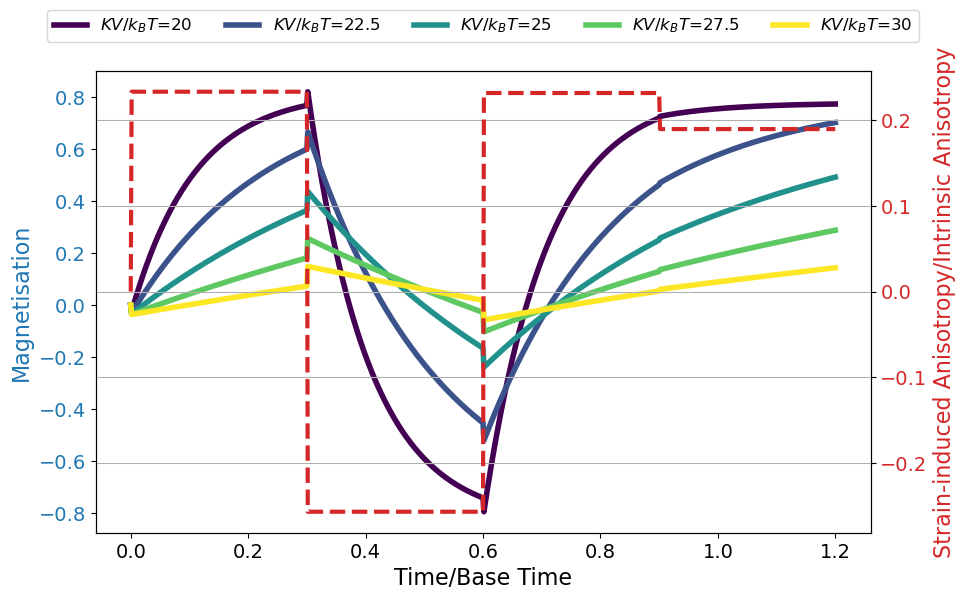

In [101]:
def plot_magnetic_properties(beta_primes):
    klist = np.random.uniform(-0.4, 0.4, 4)
    density = 200
    theta = 0.3
    beta_cons = 25

    # 自动生成颜色和标签
    colors = plt.cm.viridis(np.linspace(0, 1, len(beta_primes)))
    labels = [f'$KV/k_BT$={beta_prime}' for beta_prime in beta_primes]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    for beta_prime, color, label in zip(beta_primes, colors, labels):
        spnc = spnc_anisotropy(0.4, 90, 0, 45, beta_prime)
        params = {
            'theta': 0.3,
            'gamma': 0,
            'beta_prime': beta_prime,
            'delay_feedback': 0,
            'Nvirt': 400 if beta_prime != 20 else 40
        }
        K_s, thetas, mags = spnc.gen_trace_fast_delayed_feedback(klist, theta, density, params, beta_cons)
        ax1.plot(thetas, mags, label=label, color=color, linewidth=4)
        if beta_prime == 20:
            K_s_main = K_s

    ax1.set_xlabel('Time/Base Time', fontsize=16)
    ax1.set_ylabel('Magnetisation', color='tab:blue', fontsize=16)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)

    ax2 = ax1.twinx()
    ax2.plot(thetas, K_s_main, label='k', color='tab:red', linestyle='--', linewidth=3)
    ax2.set_ylabel('Strain-induced Anisotropy/Intrinsic Anisotropy', color='tab:red', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)

    plt.grid(True)
    plt.show()

# 调用函数并传递参数
beta_primes = [20,22.5, 25,27.5, 30]
plot_magnetic_properties(beta_primes)

[-0.4   -0.392 -0.384 -0.376 -0.368 -0.36  -0.352 -0.344 -0.336 -0.328
 -0.32  -0.312 -0.304 -0.296 -0.288 -0.28  -0.272 -0.264 -0.256 -0.248
 -0.24  -0.232 -0.224 -0.216 -0.208 -0.2   -0.192 -0.184 -0.176 -0.168
 -0.16  -0.152 -0.144 -0.136 -0.128 -0.12  -0.112 -0.104 -0.096 -0.088
 -0.08  -0.072 -0.064 -0.056 -0.048 -0.04  -0.032 -0.024 -0.016 -0.008
  0.     0.008  0.016  0.024  0.032  0.04   0.048  0.056  0.064  0.072
  0.08   0.088  0.096  0.104  0.112  0.12   0.128  0.136  0.144  0.152
  0.16   0.168  0.176  0.184  0.192  0.2    0.208  0.216  0.224  0.232
  0.24   0.248  0.256  0.264  0.272  0.28   0.288  0.296  0.304  0.312
  0.32   0.328  0.336  0.344  0.352  0.36   0.368  0.376  0.384  0.392
  0.4  ]


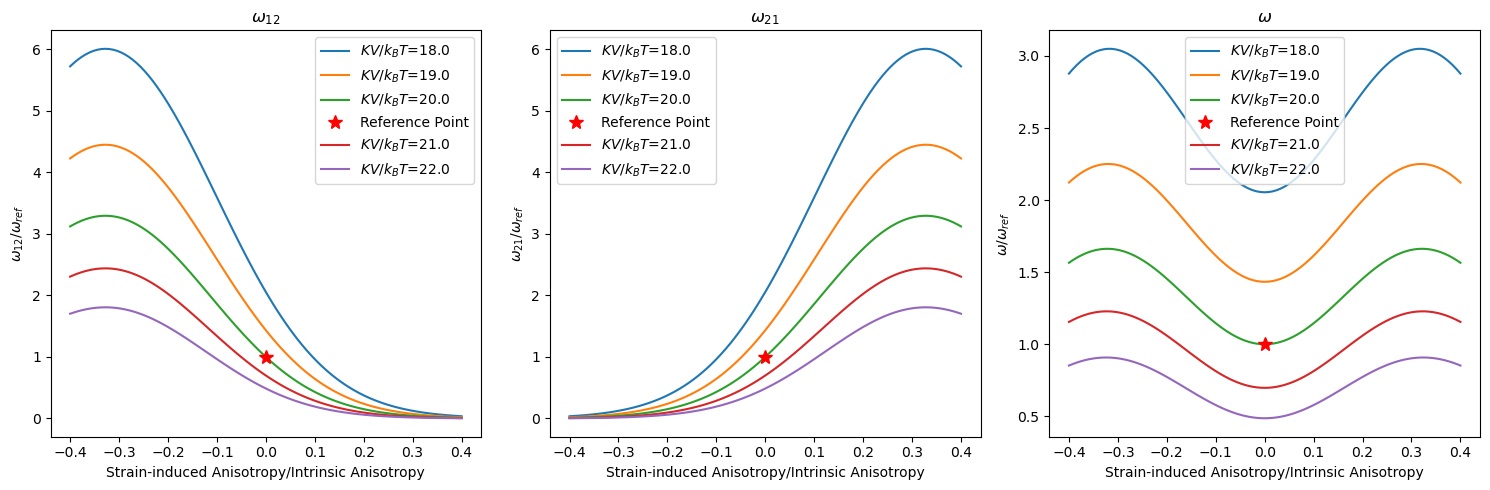

In [6]:


def plot_omega_properties(beta_primes):
    klist = np.linspace(-0.4, 0.4, 101)
    print(klist)
    omega12_lists = [[] for _ in beta_primes]
    omega21_lists = [[] for _ in beta_primes]
    omega_lists = [[] for _ in beta_primes]

    # 初始化基准值和基准点索引
    omega12_ref = None
    omega21_ref = None
    omega_ref = None
    ref_k_index = None
    ref_beta_index = None

    # 计算 omega 值
    for beta_index, beta_prime in enumerate(beta_primes):
        for k_index, k in enumerate(klist):
            k_s = k
            spnc = spnc_anisotropy(0.4, 90, k_s, 45, beta_prime)
            omega12 = spnc.get_omega_prime_12()
            omega21 = spnc.get_omega_prime_21()
            omega = spnc.get_omega_prime()
            omega12_lists[beta_index].append(omega12)
            omega21_lists[beta_index].append(omega21)
            omega_lists[beta_index].append(omega)

            # 记录基准值和索引
            if beta_prime == 20.0 and np.isclose(k_s, 0.0):
                omega12_ref = omega12
                omega21_ref = omega21
                omega_ref = omega
                ref_k_index = k_index
                ref_beta_index = beta_index

    if omega12_ref is None or omega21_ref is None or omega_ref is None:
        raise ValueError("Reference values for beta_prime=20.0 and k_s=0.0 were not found.")
    
    # 均一化
    omega12_lists = [[val / omega12_ref for val in omega12_list] for omega12_list in omega12_lists]
    omega21_lists = [[val / omega21_ref for val in omega21_list] for omega21_list in omega21_lists]
    omega_lists = [[val / omega_ref for val in omega_list] for omega_list in omega_lists]

    # 绘图
    plt.figure(figsize=(15, 5))

    # 子图1: omega12
    plt.subplot(1, 3, 1)
    for beta_index, beta_prime in enumerate(beta_primes):
        plt.plot(klist, omega12_lists[beta_index], label=f'$KV/k_BT$={beta_prime}')
        if beta_index == ref_beta_index:
            plt.plot(klist[ref_k_index], omega12_lists[beta_index][ref_k_index], 'r*', 
                    markersize=10, label='Reference Point')
    plt.title(r'$\omega_{12}$')
    plt.xlabel('Strain-induced Anisotropy/Intrinsic Anisotropy')
    plt.ylabel(r'$\omega_{12}/ \omega_{ref}$')
    plt.legend()

    # 子图2: omega21
    plt.subplot(1, 3, 2)
    for beta_index, beta_prime in enumerate(beta_primes):
        plt.plot(klist, omega21_lists[beta_index], label=f'$KV/k_BT$={beta_prime}')
        if beta_index == ref_beta_index:
            plt.plot(klist[ref_k_index], omega21_lists[beta_index][ref_k_index], 'r*', 
                    markersize=10, label='Reference Point')
    plt.title(r'$\omega_{21} $')
    plt.xlabel('Strain-induced Anisotropy/Intrinsic Anisotropy')
    plt.ylabel(r'$\omega_{21}/ \omega_{ref}$')
    plt.legend()

    # 子图3: omega
    plt.subplot(1, 3, 3)
    for beta_index, beta_prime in enumerate(beta_primes):
        plt.plot(klist, omega_lists[beta_index], label=f'$KV/k_BT$={beta_prime}')
        if beta_index == ref_beta_index:
            plt.plot(klist[ref_k_index], omega_lists[beta_index][ref_k_index], 'r*', 
                    markersize=10, label='Reference Point')
    plt.title(r'$\omega$')
    plt.xlabel('Strain-induced Anisotropy/Intrinsic Anisotropy')
    plt.ylabel(r'$\omega/ \omega_{ref}$')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 调用函数
beta_primes = [18.0, 19.0, 20.0, 21.0, 22.0]
plot_omega_properties(beta_primes)



applied voltage: 0.0
applied voltage: 0.049999999999999996
applied voltage: 0.09999999999999999
applied voltage: 0.15
applied voltage: 0.19999999999999998
applied voltage: 0.24999999999999997
applied voltage: 0.3


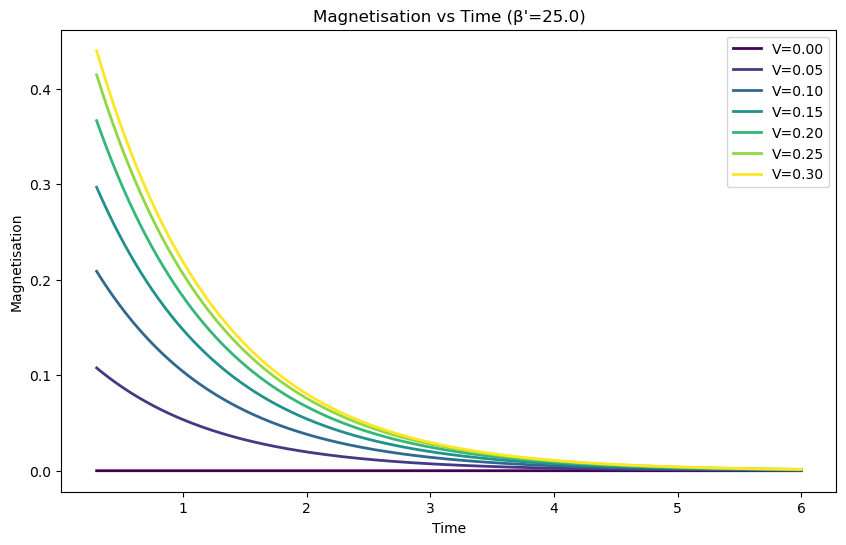

In [27]:
# Reservoir's fading memory: normalized magnetisation as a function of time

def get_magnetisation_vs_time(bp, voltage_range, density = 200):
    
    # Create a reservoir
    spnc = spnc_anisotropy(0.4,90,0,45,bp)
    theta = 0.3
    density = 200

    # set a result dataset
    result={}

    # loop
    for voltage in voltage_range: 
        
        print(f'applied voltage: {voltage}')  

        klist = np.random.uniform(-0.4, 0.4, 20)
        # klist中元素变成第一个为voltage，其余为0
        klist[0] = voltage
        klist[1:] = 0.0

        params = {
            'theta': 0.1,
            'gamma': 0,
            'beta_prime': bp,
            'delay_feedback': 0,
            'Nvirt': 400 if bp != 20 else 40
        }
        K_s, thetas, mags = spnc.gen_trace_fast_delayed_feedback(klist, theta, density, params, bp)

        # record the result
        result[voltage] = {
            'time': thetas,
            'magnetisation': mags
        }

    # 修正后的绘图部分
    plt.figure(figsize=(10, 6))
    
    # 为每个电压画一条曲线
    colors = plt.cm.viridis(np.linspace(0, 1, len(voltage_range)))
    for i, voltage in enumerate(voltage_range):
        plt.plot(result[voltage]['time'][density+1:], result[voltage]['magnetisation'][density+1:], 
                color=colors[i], label=f'V={voltage:.2f}', linewidth=2)
    
    plt.xlabel('Time')
    plt.ylabel('Magnetisation')
    plt.title(f'Magnetisation vs Time (β\'={bp})')
    plt.legend()
    plt.show()

    return result

def main():
    bp = 25.0
    voltage_range = np.linspace(0, 0.3, 7)

    result = get_magnetisation_vs_time(
    bp, voltage_range
)

    return result

if __name__ == '__main__':
    main()





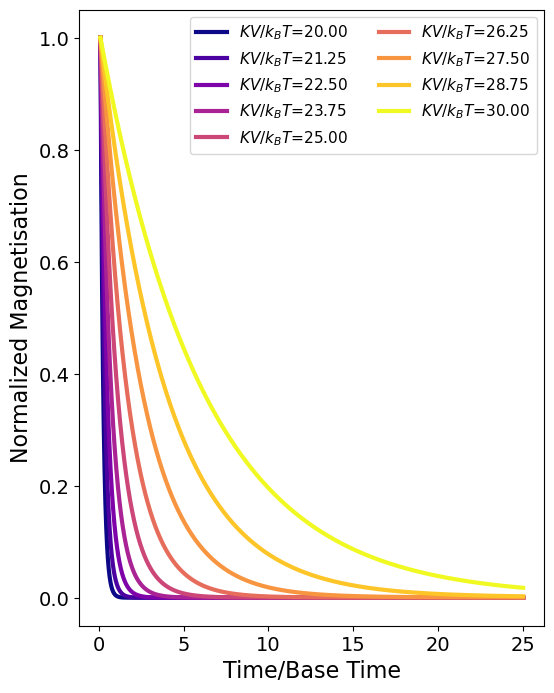

In [48]:
from scipy.optimize import curve_fit
import pickle

def exp_decay(t, M0, lambd):
    return M0 * np.exp(-lambd * t)

def calculate_magnetisation_vs_time_vs_bp(beta_prime_range, voltage, density=200):
    """
    计算相同电压下，不同beta_prime参数下磁化强度随时间的演化数据
    返回计算结果用于后续绘图或分析
    """
    # set a result dataset
    result = {}
    
    # 循环不同的bp
    for bp in beta_prime_range:
        print(f'beta_prime: {bp}')

        # Create a reservoir
        spnc = spnc_anisotropy(0.4, 90, 0, 45, bp)
        theta = 0.1

        klist = np.random.uniform(-0.4, 0.4, 250)
        klist[0] = voltage
        klist[1:] = 0.0

        params = {
            'theta': 0.1,
            'gamma': 0,
            'beta_prime': bp,
            'delay_feedback': 0,
            'Nvirt': 400 if bp != 20 else 40
        }
        K_s, thetas, mags = spnc.gen_trace_fast_delayed_feedback(klist, theta, density, params, 25)
        mags_norm = mags / np.amax(mags)

        # fit the decay
        t_fit = thetas[density+1:]
        m_fit = mags_norm[density+1:]
        popt, _ = curve_fit(exp_decay, t_fit, m_fit)
        decay_rate = popt[1]

        # record the result
        result[bp] = {
            'time': thetas,
            'magnetisation': mags,
            'magnetisation_norm': mags_norm,
            'decay_rate': decay_rate
        }
        print(f'decay_rate: {decay_rate}')

    # save the result
    with open('magnetisation_vs_time_vs_bp.pkl', 'wb') as f:
        pickle.dump(result, f)
    
    return result

def plot_magnetisation_vs_time_vs_bp(filename, beta_prime_range, density=200):
    """
    绘制相同电压下，不同beta_prime参数下磁化强度随时间的演化图
    """
    # load the result
    with open(filename, 'rb') as f:
        result = pickle.load(f)

    plt.figure(figsize=(6,8))
    colors = plt.cm.plasma(np.linspace(0, 1, len(beta_prime_range)))
    for i, bp in enumerate(beta_prime_range):
        plt.plot(result[bp]['time'][density+1:], result[bp]['magnetisation_norm'][density+1:],
                 color=colors[i],label=f'$KV/k_BT$={bp:.2f}', linewidth=3)
    plt.xlabel('Time/Base Time', fontsize=16)
    plt.ylabel('Normalized Magnetisation', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    plt.legend(ncol=2, fontsize=11)
    plt.show()

# 用法示例
def main():
    voltage = 0.4   # 你需要对比时的电压值
    beta_prime_range = np.linspace(20, 30, 9)  
    
    # 方法1：计算并绘图（原来的方式）
    # result = get_magnetisation_vs_time_vs_bp(beta_prime_range, voltage, density=200)
    
    # 方法2：分别计算和绘图（新的方式，避免重复计算）
    # result = calculate_magnetisation_vs_time_vs_bp(beta_prime_range, voltage, density=200)

    plot_magnetisation_vs_time_vs_bp('magnetisation_vs_time_vs_bp.pkl', beta_prime_range, density=200)
    

if __name__ == '__main__':
    main()

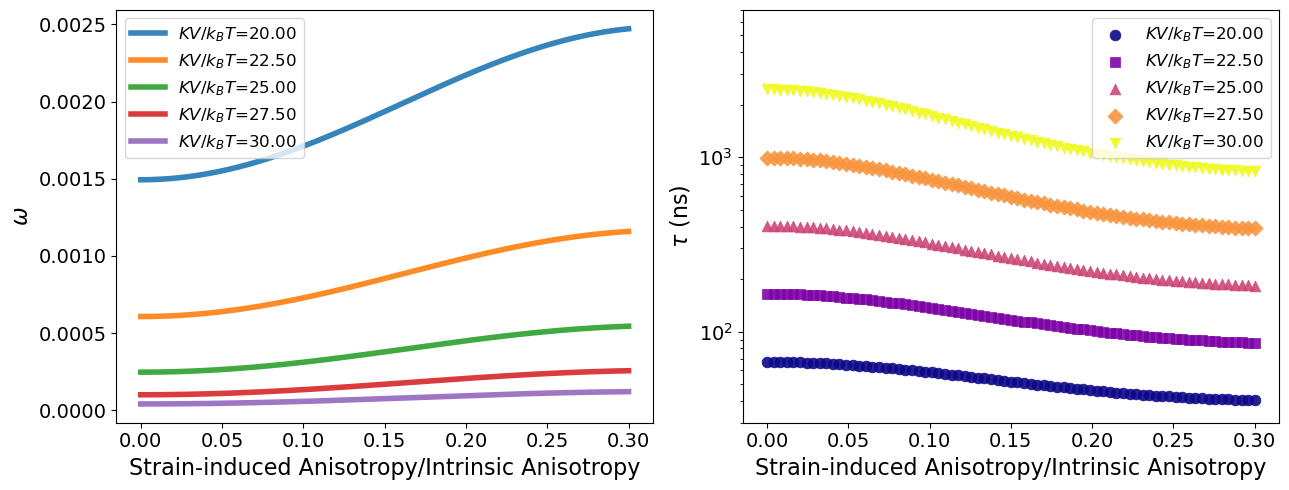

In [23]:
import pandas as pd
import seaborn as sns
def get_tau_vs_voltage(bp_range, voltage_range, density = 200):
    result = {}

    for bp in bp_range:
        for voltage in voltage_range:
            # print(f'applied voltage: {voltage}')

            spnc = spnc_anisotropy(0.4, 90, 0, 45, bp)
            spnc.k_s = voltage

            calculate_energy_barriers(spnc)

            omega_prime = spnc.get_omega_prime()
            tau = 1. / (omega_prime * spnc.f0) 
            # convert to ns
            tau = tau * 1e9

            result[(bp, voltage)] = {
                'voltage': voltage,
                'omega_prime': omega_prime,
                'tau': tau}



    # save the result
    with open('tau_vs_voltage.pkl', 'wb') as f:
        pickle.dump(result, f)

    return result

def plot_omega_and_tau_vs_voltage(filename, bp_range):
           """
           合并函数：画一个包含两个子图的图，分别显示omega和tau与电压的关系
           """
           # load the result
           with open(filename, 'rb') as f:
               result = pickle.load(f)

           # convert to dataframe
           df = pd.DataFrame([{'bp': k[0], 'voltage': k[1], **v} for k, v in result.items()])

           # 获取唯一的beta_prime值
           unique_bp = sorted(df['bp'].unique())

           # 定义不同的点形状和颜色
           markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h', 'x', '+']
           colors2 = plt.cm.plasma(np.linspace(0, 1, len(unique_bp)))
           colors1 = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

           # 创建包含两个子图的图形
           fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

           # 左侧子图：omega_prime vs voltage
           from scipy.interpolate import interp1d
           
           for i, bp in enumerate(unique_bp):
               sub_df = df[df['bp'] == bp].sort_values('voltage')
               # 插值
               f_interp = interp1d(sub_df['voltage'], sub_df['omega_prime'], kind='cubic')
               voltage_interp = np.linspace(sub_df['voltage'].min(), sub_df['voltage'].max(), 200)
               omega_interp = f_interp(voltage_interp)
               ax1.plot(voltage_interp, omega_interp,
                        color=colors1[i],
                        label=f'$KV/k_BT$={bp:.2f}',
                        linewidth=4,
                        alpha=0.9)
               # 可选：也画出原始点
               # ax1.scatter(sub_df['voltage'], sub_df['omega_prime'],
               #            marker=markers[i % len(markers)],
               #            color=colors1[i],
               #            s=30,
               #            alpha=0.5,
               #            linewidth=0.5)

           ax1.set_xlabel('Strain-induced Anisotropy/Intrinsic Anisotropy', fontsize = 16)
           ax1.set_ylabel(r'$\omega$', fontsize = 16)
           ax1.tick_params(axis='x', labelsize=14)
           ax1.tick_params(axis='y', labelsize=14)

           ax1.legend(loc='upper left', ncol=1, fontsize=12)
        #    ax1.set_title('Omega Prime vs Voltage')

           # 右侧子图：tau vs voltage
           for i, bp in enumerate(unique_bp):
               sub_df = df[df['bp'] == bp]
               ax2.scatter(sub_df['voltage'], sub_df['tau'],
                          marker=markers[i % len(markers)],
                          color=colors2[i],
                          s=60,
                          label=f'$KV/k_BT$={bp:.2f}',
                          alpha=0.9,
                          linewidth=0.5)

           ax2.set_xlabel('Strain-induced Anisotropy/Intrinsic Anisotropy', fontsize = 16)
           ax2.set_ylabel(r'$\tau$ (ns)', fontsize = 16)
           ax2.set_ylim(30, 7000)
           ax2.set_yscale('log')
           
           ax2.tick_params(axis='x', labelsize=14)
           ax2.tick_params(axis='y', labelsize=14)
           ax2.legend(loc='upper right', ncol=1, fontsize = 12)
        #    ax2.set_title('Tau vs Voltage')

           plt.tight_layout()
           plt.show()


def main():
    bp_range = np.linspace(20, 30, 5)
    voltage_range = np.linspace(0, 0.3, 75)

    # result = get_tau_vs_voltage(bp_range, voltage_range)
    plot_omega_and_tau_vs_voltage('tau_vs_voltage.pkl', bp_range)


if __name__ == '__main__':
    main()





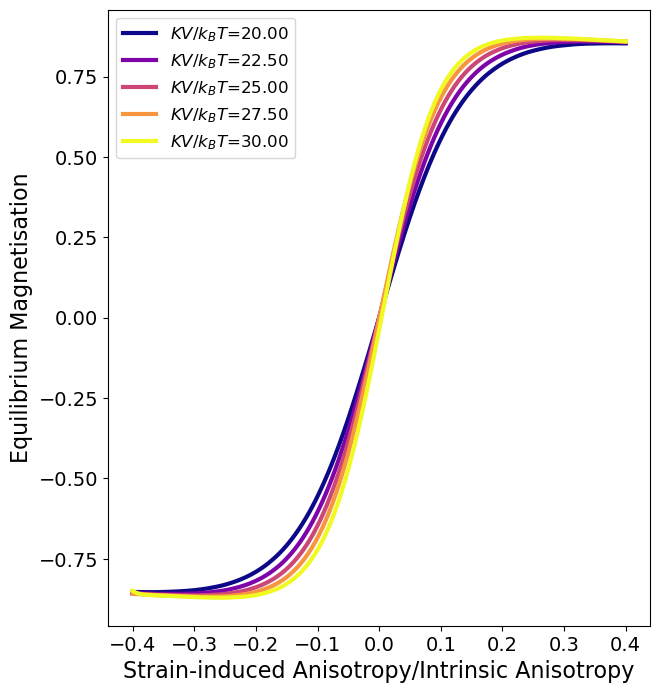

In [9]:
import pickle
import pandas as pd
def get_magnetisation_vs_time_vs_bp_nonlinear(beta_prime_range, voltage_range, density=200):
    """
    画出不同电压下,不同beta_prime参数下磁化强度随时间的演化, 只取最后时刻的点来画图
    """
    result = []
    
    for bp in beta_prime_range:
        print(f'beta_prime: {bp}')
        spnc = spnc_anisotropy(0.4, 90, 0, 45, bp)
        theta = 0.1

        for voltage in voltage_range:
            klist = np.random.uniform(-0.4, 0.4, 100)
            klist[0:] = voltage  # 全部置为同一个电压

            params = {
                'theta': 0.1,
                'gamma': 0,
                'beta_prime': bp,
                'delay_feedback': 0,
                'Nvirt': 400 if bp != 20 else 40
            }
            K_s, thetas, mags = spnc.gen_trace_fast_delayed_feedback(klist, theta, density, params, 25)
            mag = mags[-1]
            result.append({'bp': bp, 'voltage': voltage, 'final magnetisation': mag})
    return result

def plot_magnetisation_vs_voltage(filename, beta_prime_range):

    # load the result
    with open(filename, 'rb') as f:
        result = pickle.load(f)
        

    df = pd.DataFrame(result)

    plt.figure(figsize=(7,8))

    colors = plt.cm.plasma(np.linspace(0, 1, len(beta_prime_range)))

    from scipy.interpolate import interp1d
    for i, bp in enumerate(beta_prime_range):
        sub_df = df[df['bp'] == bp]
        # 对电压进行排序，避免插值异常
        sorted_sub_df = sub_df.sort_values('voltage')
        x = sorted_sub_df['voltage'].values
        y = sorted_sub_df['final magnetisation'].values
        # 使用线性插值
        interp_func = interp1d(x, y, kind='cubic', fill_value="extrapolate")
        x_dense = np.linspace(x.min(), x.max(), 300)
        y_dense = interp_func(x_dense)
        plt.plot(x_dense, y_dense, color=colors[i], label=f'$KV/k_BT$={bp:.2f}', linewidth=3)
    plt.xlabel("Strain-induced Anisotropy/Intrinsic Anisotropy", fontsize = 16)
    plt.ylabel("Equilibrium Magnetisation", fontsize = 16)
    # plt.title("Final Magnetisation vs Voltage for different β'")
    plt.legend(fontsize = 12)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()



# 用法示例
def main():
    voltage_range = np.linspace(-0.4, 0.4, 50)   # 你需要对比时的电压值
    beta_prime_range = [20,22.5,25,27.5,30]  # 不同beta_prime
    # result = get_magnetisation_vs_time_vs_bp_nonlinear(beta_prime_range, voltage_range, density=200)
    plot_magnetisation_vs_voltage('magnetisation_vs_voltage.pkl', beta_prime_range)


if __name__ == '__main__':
    main()